In [24]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import gsw as sw
import scipy.stats as ss
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

from scipy.cluster.hierarchy import fcluster

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [25]:
in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',').dropna(axis=0, subset=['depth (m)'])

data['theta'] = sw.conversions.pt_from_t(data['S'], data['T(C)'], data['depth (m)'])

data['transect'] = 0
data.loc[(data['station']<9),'transect'] = 'A'
data.loc[((data['station']>8) & (data['station']<17)),'transect'] = 'B'
data.loc[((data['station']>16) & (data['station']<26)),'transect'] = 'C'
data.loc[((data['station']>25) & (data['station']<34)),'transect'] = 'D'
data.loc[(data['station']>33),'transect'] = 'E'

data = data[data['station']!= 41]

data['station'] = data['transect'] + data['station'].astype(str) 
data['sample'] = data['station'] + '-' + data['depth (m)'].astype(int).astype(str)


# import and merge phytoplankton counts
in_file = '../data/Kuroshio_Phytoplankton.xlsx'
phyto = pd.read_excel(in_file, sheet_name = 'PFTs')
phyto = phyto[phyto['STATION']!='E41']

phyto['sample'] = phyto["STATION"] + '-' + phyto["depth"].astype(int).astype(str)
phyto = phyto[phyto['sample']!='D31-90']
phyto.set_index('sample', inplace = True)

# import chlorophyll data
# import data
chl = pd.read_csv('../data/data_CHL.csv', sep = ',')
chl = chl[['lat', 'lon', 'depth (m)','CHL']]
data = pd.merge(chl, data, left_on = ['lat', 'lon', 'depth (m)'], right_on = ['lat', 'lon', 'depth (m)'])
data.set_index('sample', inplace = True)
phyto = phyto[phyto['depth']<80]

data = data.loc[phyto.index, :]


In [26]:
## need to integrate envorinmental data here
from skbio.diversity.beta import pw_distances

# subset
# sub = phyto[['Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes',
#        u'Prasinophytes', u'Diatoms', u'Dinoflagellates']]

sub = phyto[[u'Haptophytes', u'Diatoms', u'Dinoflagellates']]
print sub.columns

# or exclude everything but dinos and diatoms
ids = sub.columns
counts = sub.iloc[0:,:]

stations = sub.index
print ids
bc_dm = pw_distances(counts, stations, metric = "braycurtis")

print np.shape(bc_dm.data)

Index([u'Haptophytes', u'Diatoms', u'Dinoflagellates'], dtype='object')
Index([u'Haptophytes', u'Diatoms', u'Dinoflagellates'], dtype='object')
(149, 149)


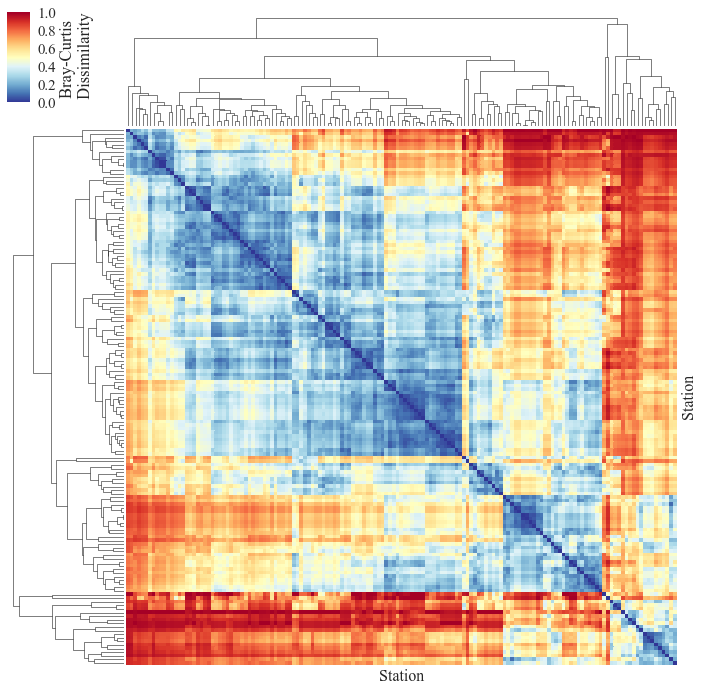

In [27]:
sns.set(font_scale=1.5)
sns.set_style("white",{'font.family': 'Times New Roman'},)

link = hierarchy.linkage(bc_dm.condensed_form(), method='average')

cm = sns.clustermap(bc_dm.data, standard_scale=1, row_linkage = link, col_linkage = link, cmap = 'RdYlBu_r',figsize=(12,12), cbar_kws={'label':'Bray-Curtis \n Dissimilarity'})
ax = cm.ax_heatmap
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Station', fontsize = 16)
ax.set_ylabel('Station', fontsize = 16)

cm.savefig('../figures/Figure3.png',dpi = 300)

1
2
3
4
5
6
7
8
9


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


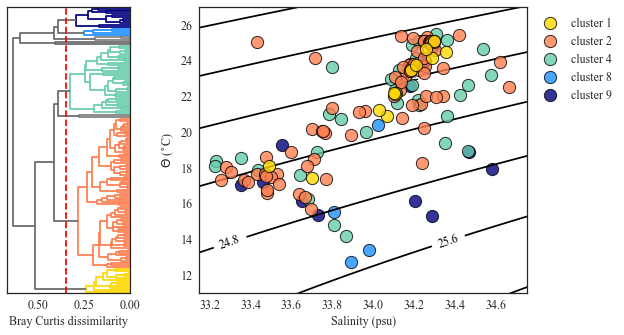

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     149
number of groups                  9
test statistic               48.452
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [28]:
# Z = hierarchy.linkage(1 - bc_dm.data, 'ward')
# palette = ['red','orange', 'blue', 'lightblue']

crit_dist = 0.35

from scipy.cluster.hierarchy import fcluster
max_d = crit_dist

clusters = fcluster(link, max_d, criterion='distance')
temp = data[['station','depth (m)','S','theta']]
temp['cluster'] = clusters


palette = plt.get_cmap('hsv', np.max(clusters)+3)
colours = ['#%02x%02x%02x' % tuple(col * 255 for col in palette(i)[:3])
          for i in range(palette.N)]

colours = ['gold', 'coral', 'grey', 'mediumaquamarine', 'grey','dodgerblue', 'navy']#, 'goldenrod', 'deeppink', 'limegreen']

from matplotlib import gridspec

fig1 = plt.figure(figsize=(8,5), dpi = 300)
#set fontsize
nn = 12

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 4]) 
ax1 = plt.subplot(gs[0])

# ax1.set_ylabel('Station - Depth',fontsize = nn)
ax1.set_xlabel('Bray Curtis dissimilarity',fontsize = nn)
 
ax1.yaxis.set_ticks_position("right") # ticks and ticklabels 
ax1.yaxis.set_label_position("right") # axis label 

hierarchy.set_link_color_palette(colours)
# hierarchy.set_link_color_palette(palette)
dend = hierarchy.dendrogram(
    link,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="left", 
    color_threshold = crit_dist, 
    above_threshold_color='dimgrey'
)
ax1.axvline(crit_dist, linestyle = '--', color = 'red')
# ax1.set_xlim([0, 1])

ax1.set_yticklabels([])
ax2 = plt.subplot(gs[1])

# print np.max(clusters)

SS = np.arange(30,36,0.1)
TT = np.arange(9, 28, 0.1)

ss, tt = np.meshgrid(SS, TT, indexing='ij')

den = sw.density_enthalpy_48.sigma0(ss, tt)

ax2.set_xlim([33.15, 34.75])
ax2.set_ylim([11, 27])

cs = ax2.contour(ss, tt, den, [21.6, 22.4, 23.2, 24.0, 24.8, 25.6, 26.4], zorder = 0, colors = 'k', ew = 1)
ax2.clabel(cs, inline=1, fontsize=nn, fmt='%3.1f')

i = 0
cc = ['gold', 'coral', 'mediumaquamarine', 'dodgerblue', 'navy']

aa = 5
for c in range(1,np.max(clusters)+1):
    print c
    lab = 'cluster %d' %c
    ctemp = temp[temp['cluster'] == c]
    if len(ctemp)>3:
        cb = ax2.scatter(ctemp['S'].values, ctemp['theta'].values, s = 150,c= cc[i], marker = 'o',lw = 1, alpha = 0.8, edgecolor = 'k', label = lab, zorder = aa)
        i += 1
    aa -= 1
ax2.set_xlabel('Salinity (psu)', fontsize = nn)
ax2.set_ylabel(r'$\Theta$ ($^{\circ}$C)', fontsize = nn)

ax2.tick_params(axis='both', which='major', labelsize = nn)
ax2.tick_params(axis='both', which='minor', labelsize = nn)

ax1.tick_params(axis='both', which='major', labelsize = nn)
ax1.tick_params(axis='both', which='minor', labelsize = nn)

ax2.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize = 12)

plt.show()
fig1.savefig('../figures/Figure4.png',dpi = 300, bbox_inches='tight')

from skbio.stats.distance import permanova
print permanova(bc_dm, clusters, column=None, permutations=999)

In [29]:
for n in pd.unique(clusters):
    print n, len(temp[temp['cluster']==n])


4 36
2 78
9 11
8 4
1 13
7 3
5 1
3 2
6 1


In [30]:
from skbio.stats.ordination import RDA
phyto['cluster'] = clusters
sub['cluster'] = clusters
# X = data[['depth (m)','S', 'sigma_t', 'theta', 'SiO2 (uM)', 'NO3 (uM)','NH4(uM)','PO4 (uM)']].dropna()
X = data[['depth (m)','S', 'theta', 'NO3 (uM)','CHL' ]].dropna()#, 'SiO2 (uM)', 'NO3 (uM)']].dropna()

phyto = phyto.loc[X.index, :]
Y = phyto.iloc[:, 2:-1]

print len(Y), len(X.index)
e_vars = X.columns
thing = RDA(Y, X, stations, e_vars, scale_Y=True).scores(1)

print thing
print np.max((thing.proportion_explained)*100)


148 148
Ordination results:
	Eigvals: 14
	Proportion explained: 14
	Species: 10x14
	Site: 148x14
	Biplot: 5x5
	Site constraints: 148x14
	Species IDs: 'depth (m)', 'S', 'theta', 'NO3 (uM)', 'CHL'
	Site IDs: u'A1-0', u'A1-25', u'A1-48', u'A1-75', u'A2-0', u'A2-25', u'A2-50', u'A2-75', ...
11.5169932925


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [37]:
for n in range(1,np.max(clusters+1)):

    if len(phyto[phyto['cluster']==n]) > 3:
        print 'cluster', n
        tmp = Y[phyto['cluster']==n].sum()
        print 'number of samples in cluster:', len(Y[phyto['cluster']==n])
    #     print 'stations in cluster', n, phyto.loc[(phyto['cluster']==n), 'STATION']
        print tmp.sort_values(axis=0, ascending=False)[0:5]/np.sum(tmp)*100
        print " "
        print "--- environment ---"
        print X[phyto['cluster']==n].describe()
        print '--------' '\n' '--------' '\n'

cluster 1
number of samples in cluster: 13
Haptophytes         79.528402
Dinoflagellates      8.567318
Diatoms              6.540848
Oscillatoriaceae     2.384083
Cryptophytes         1.926493
dtype: float64
 
--- environment ---
       depth (m)          S      theta   NO3 (uM)        CHL
count  13.000000  13.000000  13.000000  13.000000  13.000000
mean   22.076923  34.091492  22.279885   0.897785   0.897710
std    17.825364   0.244996   2.409311   0.654757   0.424995
min     0.000000  33.491000  17.422033   0.085714   0.364168
25%    20.000000  34.065000  21.227672   0.430000   0.739897
50%    20.000000  34.110000  22.196000   0.810000   0.851869
75%    30.000000  34.256100  24.142600   1.457143   0.907855
max    65.000000  34.356300  25.074367   1.960000   1.840957
--------
--------

cluster 2
number of samples in cluster: 77
Haptophytes         73.144992
Dinoflagellates     10.838589
Diatoms              8.041201
Cryptophytes         2.924207
Oscillatoriaceae     2.700062
dtype: fl

In [32]:

for n in range(1,np.max(clusters+1)):
    print 'cluster', n
    
    tmp = Y[phyto['cluster']==n]
    tmp['richness'] = tmp.astype(bool).sum(axis=1)
    
    print tmp['richness'].mean(), '+/-', tmp['richness'].std()
                   


cluster 1
6.53846153846 +/- 0.660225291774
cluster 2
6.25974025974 +/- 0.833549755447
cluster 3
6.0 +/- 0.0
cluster 4
6.08333333333 +/- 0.769972170184
cluster 5
5.0 +/- nan
cluster 6
7.0 +/- nan
cluster 7
6.33333333333 +/- 1.52752523165
cluster 8
6.5 +/- 0.57735026919
cluster 9
5.90909090909 +/- 0.831209414594


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
  Haptophytes    Diatoms Dinoflagellates
1    0.840356  0.0691154       0.0905286
2    0.792472  0.0867402        0.120787
4     0.70823    0.11981         0.17196
8    0.634146   0.268293        0.097561
9    0.660459  0.0466528        0.292889


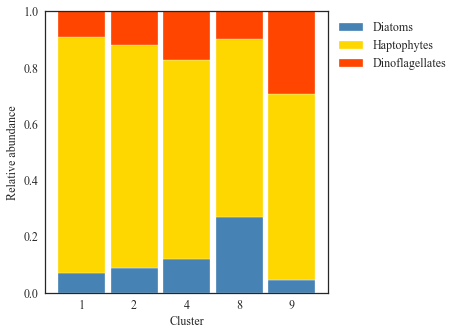

In [40]:
fig2 = plt.figure(figsize=(5,5), dpi = 300)


print len(ids)
step = 1.2
barwidth = 0.25
rank_clusters = pd.DataFrame()

bcols = colours
pclu = sub.groupby('cluster').sum()
pclu['tot'] = pclu.sum(axis=1)

# ptot = pd.DataFrame(columns = ['Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes', u'Prasinophytes', u'Diatoms', u'Dinoflagellates'])

ptot = pd.DataFrame(columns = [ u'Haptophytes', u'Diatoms', u'Dinoflagellates'])

for n in [1, 2, 4, 8, 9]:
    vv = np.float(pclu.loc[n, ['tot']])
#     print vv
#     ptot.loc[n,] = pclu.loc[n, ['Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes', u'Prasinophytes', u'Diatoms', u'Dinoflagellates']]/vv
    ptot.loc[n,] = pclu.loc[n, [u'Haptophytes', u'Diatoms', u'Dinoflagellates']]/vv


print ptot


# plot
r = [1, 2, 4, 8, 9]
rx = [1, 2, 3, 4, 5]

barWidth = 0.9

# ax1 = fig2.add_subplot(111)
# # Create green Bars
# ax1.bar(r, ptot['Oscillatoriaceae'], color='steelblue', edgecolor='white', width=barWidth, label = 'Oscillatoriaceae')
# # Create orange Bars
# ax1.bar(r, ptot['Cryptophytes'], bottom=ptot['Oscillatoriaceae'], color='gold', edgecolor='white', width=barWidth, label = 'Cryptophytes')
# # Create blue Bars
# ax1.bar(r, ptot['Haptophytes'], bottom=[i+j for i,j in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'])], color='coral', edgecolor='white', width=barWidth, label = 'Haptophytes')
# # Create blue Bars
# ax1.bar(r, ptot['Diatoms'], bottom=[i+j+k for i,j,k in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'])], color='mediumseagreen', edgecolor='white', width=barWidth, label = 'Diatoms')
# # Create blue Bars
# ax1.bar(r, ptot['Dinoflagellates'], bottom=[i+j+k+l for i,j,k,l in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'],ptot['Diatoms'])], color='skyblue', edgecolor='white', width=barWidth, label = 'Dinoflagellates')
# # Create blue Bars
# ax1.bar(r, ptot['Euglenophytes'], bottom=[i+j+k+l+m for i,j,k,l,m in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'],ptot['Diatoms'],ptot['Dinoflagellates'])], color='tomato', edgecolor='white', width=barWidth, label = 'Euglenophytes')
# # Create blue Bars
# ax1.bar(r, ptot['Prasinophytes'], bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'],ptot['Diatoms'],ptot['Dinoflagellates'],ptot['Euglenophytes'])], color='orangered', edgecolor='white', width=barWidth, label = 'Prasinophytes') 
   
    
ax1 = fig2.add_subplot(111)
# Create green Bars
ax1.bar(rx, ptot['Diatoms'], color='steelblue', edgecolor='white', width=barWidth, label = 'Diatoms')
# Create orange Bars
ax1.bar(rx, ptot['Haptophytes'], bottom=ptot['Diatoms'], color='gold', edgecolor='white', width=barWidth, label = 'Haptophytes')
# Create blue Bars
ax1.bar(rx, ptot['Dinoflagellates'], bottom=[i+j for i,j in zip(ptot['Diatoms'], ptot['Haptophytes'])], color='orangered', edgecolor='white', width=barWidth, label = 'Dinoflagellates')
      
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_xticklabels(['1', '2', '4', '8', '9'],fontsize = 12)
ax1.set_xlabel("Cluster", fontsize = 12)
ax1.set_ylabel('Relative abundance', fontsize = 12)
ax1.tick_params(labelsize = 12)

ax1.set_ylim([0,1])

ax1.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize = 12)
plt.show()
# fig2.savefig('../figures/Figure5.png',dpi = 300, bbox_inches='tight')

In [34]:
# pclu.to_csv('../data/phyto_byclusters.csv', sep = ',')

In [35]:
for n in range(1,np.max(clusters+1)):
    print 'dominant phyto in cluster ', n
    
    tmp = Y[phyto['cluster']==n].sum()
    print 'number of samples in cluster:', len(Y[phyto['cluster']==n])
    print 'stations in cluster', n, X[phyto['cluster']==n]

dominant phyto in cluster  1
number of samples in cluster: 13
stations in cluster 1         depth (m)        S      theta  NO3 (uM)       CHL
sample                                                   
B11-20       20.0  33.4910  18.068606  1.725494  0.901634
B15-20       20.0  34.1860  23.485374  0.085714  0.739897
B15-32       32.0  34.0650  20.868449  1.457143  0.851869
C25-0         0.0  34.1100  22.196000  0.171429  1.840957
C25-20       20.0  34.1070  22.137051  0.171429  1.629454
D28-0         0.0  34.0990  22.180000  0.990000  1.057151
D28-20       20.0  34.0280  21.227672  1.800000  0.752338
D31-30       30.0  33.6990  17.422033  1.960000  0.907855
E35-20       20.0  34.2077  23.732542  0.690000  0.892925
E36-0         0.0  34.2858  24.142600  0.810000  0.474896
E36-20       20.0  34.2985  25.074367  0.440000  0.454990
E36-40       40.0  34.2561  24.653541  0.430000  0.802103
E40-65       65.0  34.3563  24.450265  0.940000  0.364168
dominant phyto in cluster  2
number of samples

In [36]:
cluster_stn = phyto[['STATION', 'depth', 'latitude', 'longitude', 'cluster']]
# cluster_stn.to_csv('../data/cluster_stations.csv',sep = ',')